In [20]:
import torch
import torch.nn as nn 
from torchvision import  datasets, models, transforms 
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
import time
import os 
from collections import Counter
import torch.optim as optim
from torchvision.models import DenseNet121_Weights
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize


In [21]:
transform = transforms.Compose([
    
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #* imageNet stander 
])

In [22]:
data_dir = './Datasets/LungXRays-grayscale'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
print(f'training data: {len(train_dataset)}')
print(f'validation data: {len(val_dataset)}')
print(f'test data: {len(test_dataset)}')

 


training data: 4861
validation data: 1620
test data: 1625


In [23]:
#TODO  check for the distribuation classes
def get_class_distribution(dataset): 
    counter_pr_class = Counter([dataset.classes[label] for _, label in dataset.imgs])
    return counter_pr_class   
train_distribution = get_class_distribution(train_dataset)
print(train_distribution)


Counter({'COVID19': 1218, 'Pneumonia': 1218, 'Tuberculosis': 1218, 'Normal': 1207})


In [24]:
##* datasets loader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
imgs, labels = next(dataiter)
print(imgs.shape)
print(torch.min(imgs), torch.max(imgs))
print(f'images shapes: {imgs.shape}')

torch.Size([32, 3, 224, 224])
tensor(-2.1179) tensor(2.6400)
images shapes: torch.Size([32, 3, 224, 224])


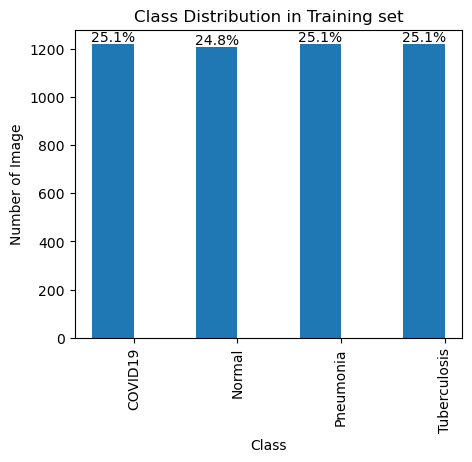

In [25]:
def plot_combined_distributions(original_dist,  dataset_name='Training Set'): 
    
    classes = list(original_dist.keys())
    original_counts = [original_dist[cls] for cls in classes]
    total_count = sum(original_counts)
 
    
    x = range(len(classes))
    width = 0.4 
    
    plt.figure(figsize=(5, 4))
    bars = plt.bar(x, original_counts, width=width, label = 'Original', align='center')
    #plt.bar([p + width for p in x], sample_counts, width=width, label ='weighted sampled', align='center')
    
    
    for bar, count in zip(bars, original_counts): 
        percent = (count / total_count) * 100
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height(), 
            f'{percent:.1f}%', 
            ha= 'center', 
            va=  'bottom'
        )
        

    plt.xlabel('Class')
    plt.ylabel('Number of Image')
    plt.title('Class Distribution in Training set')

    plt.xticks([p+width / 2 for p in x], classes, rotation = 90)
   
    plt.show()

plot_combined_distributions(train_distribution )




In [26]:
#pred trained model DenseNet121 
num_classes = len(train_dataset.classes)
densenet121_model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
#making modification of the number of class
densenet121_model.classifier = nn.Linear(densenet121_model.classifier.in_features, num_classes)


In [27]:
#Hyperparamaters 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = densenet121_model.to(device) 
criterion = nn.CrossEntropyLoss();  
optimizer = optim.Adam(model.parameters(), lr=0.00001 )
#optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
num_epoch = 20

In [28]:
#* we need to train the module 

def train_model(model, train_loader, criterion, optimizer, device):
    

        #* we sting the model into train mode
    model.train(); 
    
    learning_loss = 0.0; 
    correct = 0; 
    total = 0; 
    
    for inputs, labels in train_loader: 
        
        inputs, labels = inputs.to(device), labels.to(device)
        #* starting with the gradient from  the intial point 0 
        optimizer.zero_grad()
        outputs = model(inputs); 
        loss = criterion(outputs, labels); 
        loss.backward();
        optimizer.step(); 
        learning_loss += loss.item(); 
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item(); 
    
    learning_loss_result = learning_loss / total if total > 0 else 0
    train_acc = 100 * correct /total if total > 0 else 0
    return learning_loss_result, train_acc
                

In [29]:
### evaluation the model

def validation(model, val_loader, criterion, device ): 
    model.eval(); 
    running_loss = 0.0; 
    total = 0; 
    correct = 0; 
    
    with torch.no_grad(): 
        for inputs, labels in val_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            running_loss += loss.item(); 
            _,predict = torch.max(outputs, 1); 
            
            total  += labels.size(0); 
            correct  += (predict == labels).sum().item()
            
    result_running_loss = running_loss / total if total > 0 else 0 
    result_val_acc = 100* correct / total if total > 0 else 0; 
    return  result_running_loss, result_val_acc; 

In [30]:
class EarlyStopping:
    def __init__(self, patience =5, delta = 0, path='best.pt'):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
        
           
            self.best_loss = val_loss 
            self.Save_best_model(model)
            self.counter = 0
        else: 
            self.counter += 1 
            print(f'Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
    
    def Save_best_model(self, model): 
        torch.save(model.state_dict(), self.path)
             

In [31]:
earlyStopping = EarlyStopping(patience=5,  path='best_denseNet121.pth')
start_time = time.time()
train_losses, train_accs, val_losses, val_accs =[], [], [], []
for epoch in range(num_epoch):
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    train_losses.append(train_loss); 
    train_accs.append(train_acc); 
    val_losses.append(val_loss)
    val_accs.append(val_acc); 
    

    print(f'Epoch {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    earlyStopping(val_loss, model)
    if earlyStopping.early_stop: 
        print('Note early stopping is triggered no need more training')
        break
end_time = time.time()
print(f'Training Time for DenseNet121: {end_time - start_time:.2f} seconds')

Epoch 1/20: Train Loss: 0.0261 Train Acc: 72.7422, Val Loss: 0.0146, Val Acc: 89.0123
Epoch 2/20: Train Loss: 0.0110 Train Acc: 91.0718, Val Loss: 0.0078, Val Acc: 93.3333
Epoch 3/20: Train Loss: 0.0074 Train Acc: 93.3141, Val Loss: 0.0056, Val Acc: 95.0000
Epoch 4/20: Train Loss: 0.0053 Train Acc: 94.9187, Val Loss: 0.0046, Val Acc: 95.3086
Epoch 5/20: Train Loss: 0.0045 Train Acc: 95.6799, Val Loss: 0.0041, Val Acc: 96.1111
Epoch 6/20: Train Loss: 0.0037 Train Acc: 96.5851, Val Loss: 0.0035, Val Acc: 97.0988
Epoch 7/20: Train Loss: 0.0034 Train Acc: 96.7085, Val Loss: 0.0035, Val Acc: 96.7284
Early stopping counter: 1 out of 5
Epoch 8/20: Train Loss: 0.0030 Train Acc: 97.0582, Val Loss: 0.0031, Val Acc: 96.9136
Epoch 9/20: Train Loss: 0.0025 Train Acc: 97.2845, Val Loss: 0.0031, Val Acc: 96.9753
Early stopping counter: 1 out of 5
Epoch 10/20: Train Loss: 0.0022 Train Acc: 97.8811, Val Loss: 0.0030, Val Acc: 96.8519
Epoch 11/20: Train Loss: 0.0020 Train Acc: 98.1897, Val Loss: 0.0027,

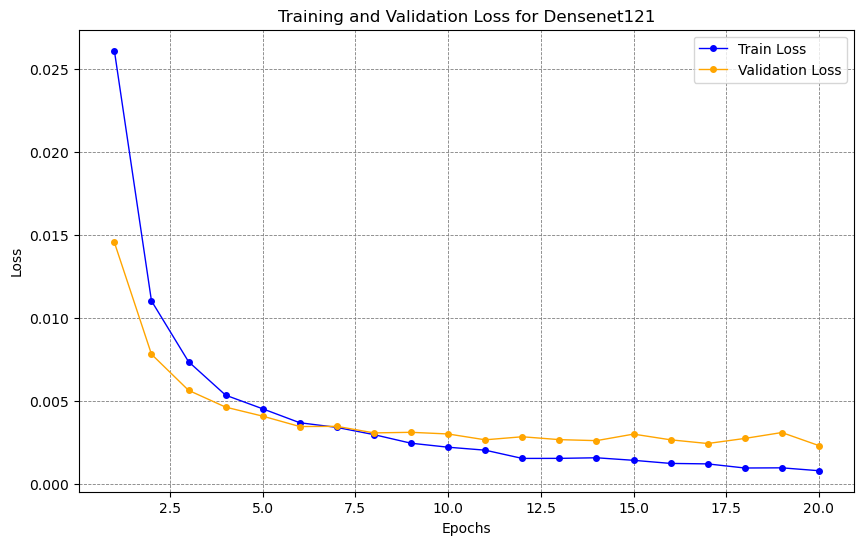

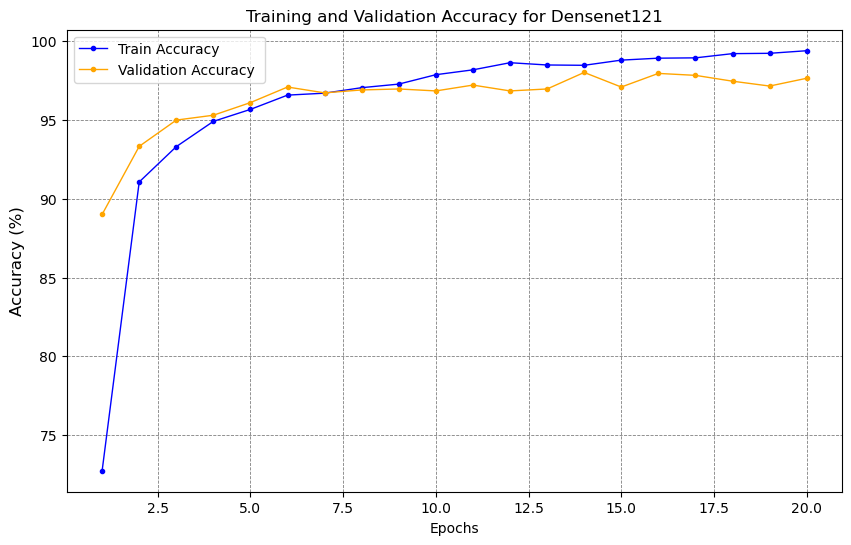

In [52]:
def Plot_metrics(train_losses, val_losses, train_accs, val_accs):
    #* range for the plot 
    epoch = range(1, len(train_losses)+1)
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_losses, label= 'Train Loss', color = 'blue',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.plot(epoch, val_losses, label='Validation Loss', color='orange',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Densenet121')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_accs, label= 'Train Accuracy ', color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.plot(epoch, val_accs, label='Validation Accuracy ', color='orange',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training and Validation Accuracy for Densenet121')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()



Plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [46]:
densenet121_model.load_state_dict(torch.load('best_denseNet121.pth' , weights_only=True))
model = densenet121_model.to(device)


In [49]:
# evaluation 

#*  Model evaluation 
def evaluation(model, test_loader, criterion, device):
    test_loss = 0.0
    all_pred = []
    all_labels = []
    all_probs = []   
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
       
            _, predicted = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            all_pred.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
  
    result_test_loss = test_loss / len(test_loader)
    result_test_acc = 100 * correct / total
    
     
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs) 
    num_classes = all_probs.shape[1]
    y_true = label_binarize(all_labels, classes=range(num_classes))
    auc = roc_auc_score(y_true, all_probs, multi_class='ovr', average='macro')
    
    
    return result_test_loss, result_test_acc, all_pred, all_labels, auc, all_probs

In [50]:
## testing accuracy 
test_loss, test_acc, all_preds, all_labels, auc, all_probs= evaluation(model, test_loader, criterion, device)
print(f'Test Accuaracy: {test_acc:.2f} AUC: {auc:.2f}')

Test Accuaracy: 98.03 AUC: 1.00


Accuracy: 98.03

 classification Report
              precision    recall  f1-score   support

     COVID19     0.9926    0.9926    0.9926       407
      Normal     0.9579    0.9748    0.9663       397
   Pneumonia     0.9754    0.9566    0.9659       415
Tuberculosis     0.9951    0.9975    0.9963       406

    accuracy                         0.9803      1625
   macro avg     0.9803    0.9804    0.9803      1625
weighted avg     0.9804    0.9803    0.9803      1625



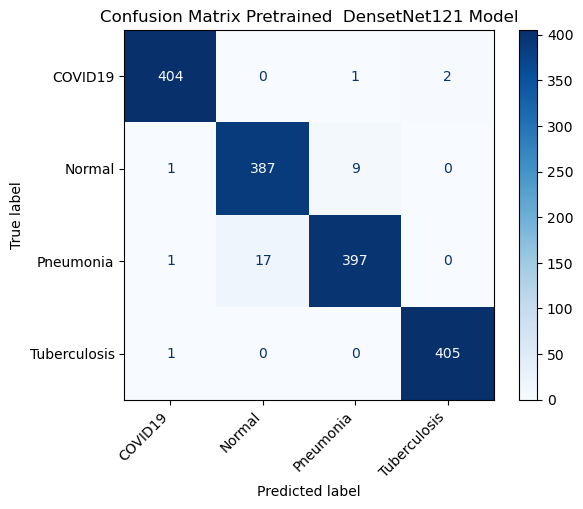

In [53]:
## Confusion metrics 
accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {100*accuracy:.2f}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels, target_names=train_dataset.classes, digits=4)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues')
plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix Pretrained  DensetNet121 Model')
plt.show()

In [60]:
#* for AUC plotting
#* plotting auc curve for each classes 

#* plotting auc curve for each classes 

def plot_roc_curve(all_labels, all_probs, num_classes, class_names):
    """
    Plot ROC curve for each class.
    Args:
        all_labels: Ground truth labels.
        all_probs: Predicted probabilities for each class.
        num_classes: Total number of classes.
        class_names: List of class names corresponding to the classes.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    
    y_true = label_binarize(all_labels, classes=range(num_classes))
    all_probs = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

 
    plt.figure(figsize=(4, 4))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve For DenseNet121')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



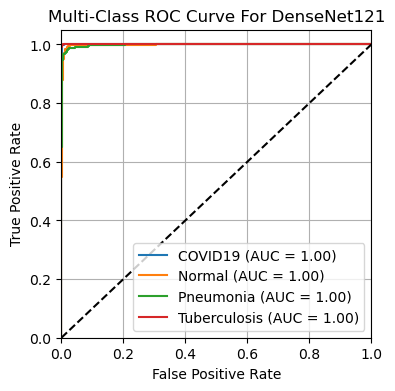

In [61]:
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes   
plot_roc_curve(all_labels, all_probs, num_classes, class_names)